In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import torch, pickle, numpy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# setup
nfft = 2**15
pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_009_996_288.0, 80_289_505_280.0
t_chirp = 0.000_064_890_002_249_740_060
hertz_per_meter = (f_end-f_start) / t_chirp / lightspeed
bins_per_meter = nfft / maxdist


folder = '/home/dgotzens/shares/messdaten/000_Products/iMCR/2023_12_15_Antenna_Gain_Variable_Range_LD_dgs/exports/'

cuda:0



loaded data for 2m. processing... 96.9%  


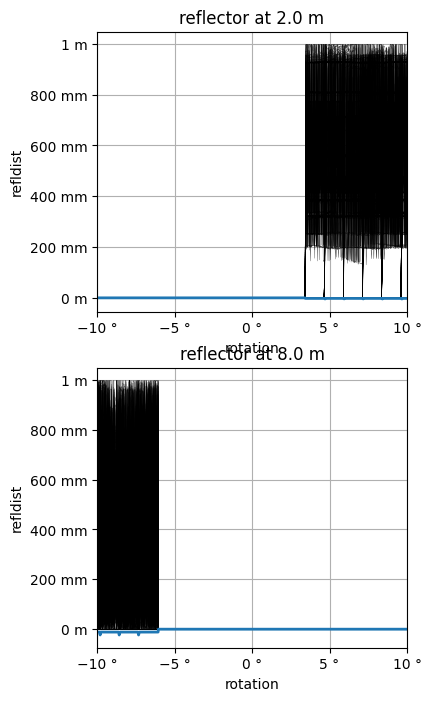

In [2]:
fig, ax = plt.subplots(2)
fig.set_size_inches((4,8))
argmin = lambda vals : vals.index(min(vals))
for n, dist in enumerate((2,8,)):
#for n, dist in enumerate((2,)):
    data = torch.load(f'{folder}a{dist:02d}_data.pt') * 2**8 / 2**11
    M,K,L = data.shape
    with open(f'{folder}a{dist:02d}_timestamps.pkl', 'rb') as f:
        timestamps = pickle.load(f)
    with open(f'{folder}a{dist:02d}_angle.pkl', 'rb') as f:
        angle = pickle.load(f)

    print('')
    # calculate mean 
    window = torch.hann_window(M).unsqueeze(-1).unsqueeze(-1).to(device)
    window = window / window.sum()

    m_bp = int((dist-0.4)*bins_per_meter)
    M_bp = int(1*bins_per_meter)

    N = 32
    data_fft = torch.zeros((nfft,K,N), dtype=torch.cfloat, device=device)
    refldist = torch.zeros(L, device=device)
    refldist_mean = torch.zeros(L, device=device)

    angle_deg = [180/pi*a - 90 for a in angle]
    l_zero = argmin([abs(a) for a in angle_deg])
    for l in range(L//2-128,L//2+128,N-1):
        data_fft[:,:,:] = torch.fft.fft(window*(data[:,:,l:l+N]).to(device), nfft, 0)
        print(f'loaded data for {dist}m. processing... {(l-L//2+128)/256*100:.1f}%', end='  \r')
        for k in range(K):
            refldist[l:l+N] = data_fft[m_bp:m_bp+M_bp,k,:].abs().argmax(0)
            refldist_mean[l:l+N] += (data_fft[m_bp:m_bp+M_bp,k,:].abs().argmax(0)/bins_per_meter-dist)/K
            ax[n].plot(angle_deg, refldist.cpu()/bins_per_meter, color='k', linewidth=.2)
    ax[n].plot(angle_deg, refldist_mean.cpu()/bins_per_meter, linewidth=2)
    # plot data
    ax[n].yaxis.set_major_formatter(EngFormatter(unit='m'))
    ax[n].xaxis.set_major_formatter(EngFormatter(unit='°'))
    ax[n].set_title(f'reflector at {dist}.0 m')
    ax[n].set_xlabel('rotation')
    ax[n].set_ylabel('refldist')
    ax[n].set_xlim(-10,10)
    ax[n].grid()



loaded data for 2m. processing... 100.0%  
loaded data for 8m. processing... 100.0%  


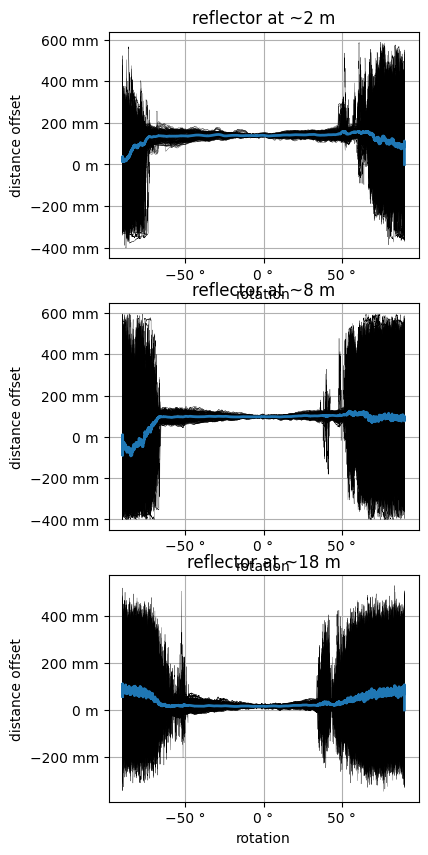

In [26]:
fig, ax = plt.subplots(3)
fig.set_size_inches((4,10))
argmin = lambda vals : vals.index(min(vals))
for n, dist in enumerate((2,8,18)):
# for n, dist in enumerate((2,)):
    data = torch.load(f'{folder}a{dist:02d}_data.pt').to(device) * 2**8 / 2**11
    M,K,L = data.shape
    with open(f'{folder}a{dist:02d}_timestamps.pkl', 'rb') as f:
        asdfff = pickle.load(f)
    with open(f'{folder}a{dist:02d}_angle.pkl', 'rb') as f:
        angle = pickle.load(f)

    print('')
    # calculate mean 
    window = torch.hann_window(M).unsqueeze(-1)
    window = window / window.sum()

    
    m_bp = int((dist-0.4)*bins_per_meter)
    M_bp = int(1*bins_per_meter)

    data_fft = torch.zeros((nfft,K), dtype=torch.cfloat, device=device)
    refldist = torch.zeros(K,L, device=device)
    refldist_mean = torch.zeros(L, device=device)

    angle_deg = [180/pi*a - 90 for a in angle]
    l_zero = argmin([abs(a) for a in angle_deg])
    retain = 0.7
    for l in range(1,L):
        data_fft[:,:] = torch.fft.fft(window*data[:,:,l], nfft, 0)
        print(f'loaded data for {dist}m. processing... {l/(L-1)*100:.1f}%', end='  \r')
        update = (data_fft[m_bp:m_bp+M_bp,:].abs().argmax(0) + m_bp) / bins_per_meter - dist
        refldist[:,l] = retain*refldist[:,l-1] + (1-retain)*update
        refldist_mean[l] = refldist[:,l].mean(0)
    for k in range(K):
        ax[n].plot(angle_deg, refldist[k,:], color='k', linewidth=.2)
    ax[n].plot(angle_deg, refldist_mean, linewidth=2)
    # plot data
    ax[n].yaxis.set_major_formatter(EngFormatter(unit='m'))
    ax[n].xaxis.set_major_formatter(EngFormatter(unit='°'))
    ax[n].set_title(f'reflector at ~{dist} m')
    ax[n].set_xlabel('rotation')
    ax[n].set_ylabel('distance offset')
    ax[n].grid()